<a href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/solved-notebooks/SOLVED-Lab-3.LinearLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Linear and Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from numpy.linalg import inv

## Data Geneation (cfr Lab 1)

Linear model $y=wx+\varepsilon$, with $ɛ \sim \mathcal{N}(0,\sigma)$


In [2]:
def datagen(d, points, m, M, w, sigma):
    """
    Parameters
    ----------
    d : int
        Dimension of each data sample
    points : int
        Number of points to be generated
    m : float
        Lower bound for the domain of the data points
    M : float
        Upper bound for the domain of the data points
    w : float array of dim d 
        Vector of weights of the linear model
    sigma : float
        Standard deviation of the noise eps
    """
    X = np.zeros((points, d))
    for i in range(points):
        X[i,:] = np.random.uniform(m, M, d)
    eps = np.random.normal(0, sigma, points)
    y = np.dot(X, w) + eps 
    return X, y

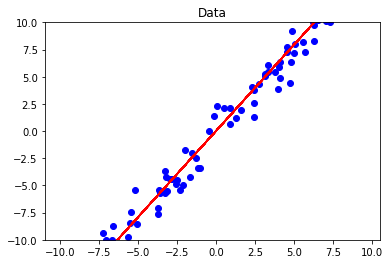

In [3]:
# usage example 
d = 1
w = np.random.normal(0, 1, d)
sigma = 1
points = 100
m = -10
M = 10

X_reg, y_reg = datagen(d, points, m, M, w, sigma)

# plotting the generated dataset
fig, ax = plt.subplots()
ax.scatter(X_reg, y_reg, c='b')
ax.plot(X_reg, np.dot(X_reg, w), '--', c='r')
ax.set_title('Data')
plt.ylim([m, M])

fig.show()

## Linear Regression 

Given a dataset $\mathcal{D}=\{(x_i, y_i)\}_{i=1}^n ⊆ \mathbb{R}^d \times \mathbb{R}$ we want to compute the best fitting line, i.e. the parameters $w$ of the line $y=w\cdot X$.

### Analytic Solution

* **Ordinary Linear Regression (i.e. no regularization):**

$$
y=Xw,\;\;\;\; w=X^{-1}y,\;\;\;\;X^{-1}=(X^{T}X)^{-1}X^{T}
$$

$$
w=(X^{T}X)^{-1}X^{T}y
$$

**Recall**: we cannot invert a matrix which is not squared, so we need to resort to the Moore-Penrose pseudo-inverse, i.e. $X^{-1}\approx (X^TX)^{-1}X^T$

* **Ridge Regression**

  If $X^{T}X$ is not invertible (i.e. some eigenvalues are zero) then we regularize by adding $\lambda \mathbb{I}$, with $\mathbb{I}$ being the identity matrix of size $d\times d$ making the zero
eigenvalues $\lambda$.

$$
w=(X^{T}X+\lambda Id)^{-1}X^{T}y
$$

  The line that we find with Ridge Regression takes the form: $y = w\cdot X + \lambda \|w\|_2$ (i.e. $L_2$ penalty)

Interesting blog post showing this analytic derivation and its implementation: https://knork.medium.com/linear-regression-in-python-from-scratch-with-kernels-e9c37f7975b9

In [4]:
def CloseRegression(X, y):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    """
    w = (inv(X.T@X)@X.T)@y 
    return w

def CloseRegressionReg(X, y, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    lam : float
        Lambda term of Ridge regularization
    """
    d = np.shape(X)[1]
    w = (inv(X.T@X+lam*np.eye(d))@X.T)@y
    return w


In [5]:
wclose = CloseRegression(X_reg, y_reg)
lam = 0.01
wcloseReg = CloseRegressionReg(X_reg, y_reg, lam)
wcloseReg, wclose, np.abs(wclose-wcloseReg)

(array([1.5635408]), array([1.56354544]), array([4.63961473e-06]))

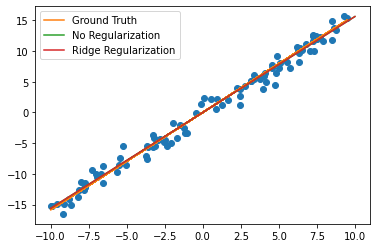

In [6]:
# plot the solution of both regressions
xlin = np.linspace(-10,10,100)
ypred = wclose*xlin
ypredreg = wcloseReg*xlin

fig, ax = plt.subplots()
ax.plot(X_reg, y_reg, 'o')
ax.plot(X_reg, np.dot(X_reg,w), label='Ground Truth')
ax.plot(xlin, ypred, label='No Regularization')
ax.plot(xlin, ypredreg, label='Ridge Regularization')
plt.legend()
fig.show()

1. Try to vary the parameter $\lambda$ and check what happens to the magnitude of the found $w$ (try to inspect it visually with a plot)

In [7]:
lambdas = np.linspace(0.00001, 1, 150)
wreg = []
for l in lambdas:
  lam = l
  wcloseReg = CloseRegressionReg(X_reg, y_reg, lam)
  wreg.append(wcloseReg)

wreg = np.array(wreg)
abs_diff = np.abs(wreg - wclose)

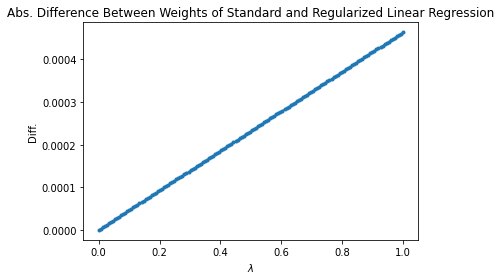

In [8]:
fig, ax = plt.subplots()
ax.plot(lambdas, abs_diff, 'o-', markersize=3, linewidth=0.8)
plt.title('Abs. Difference Between Weights of Standard and Regularized Linear Regression')
plt.xlabel(r'$\lambda$')
plt.ylabel('Diff.')
fig.show()

## Gradient Descent (GD) method

**Recall**: the gradient indicates the direction of maximal ascent of a function. Hence to find the minimum of a function we have to follow the direction of the negative gradient. In GD we take a step of size $\gamma$ (learning rate). Given a loss function $\mathcal{L}(w)$ it works as:

1. Initialize $w_0$
2. while (condition):
   * compute gradient of the loss at t $\nabla_w \mathcal{L}|_t$
   * update weights as $w_{t+1} = w_t - \gamma \nabla_w \mathcal{L}|_t $


In the case of linear regression the squared erro loss and its gradient read as:


$$
\mathcal{L}=\frac{1}{n}\|y-Xw\|_{2}^{2},\;\;\;\;\nabla_{w} \mathcal{L} = -\frac{2}{n}X(y-Xw)
$$

As condition for the while loop we use a predefined number of iterations.

In [9]:
def SquareLoss(X, y, w):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    """
    return LA.norm(y-X@w,2)

In [10]:
def GD(X, y, iter, gamma, points, d):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    """
    # initialization
    W = np.zeros((d, iter)) # to store weights
    L = np.zeros(iter) # to store losses
    w = np.random.normal(0, 0.1, d)
    # GD iterations
    for i in range(iter):
        W[:,i] = w
        w = w + (2*gamma/points)*((y-X@w)@X)
        L[i] = SquareLoss(X,y,w)
    return W, L

In [11]:
# example of usage
d = np.shape(X_reg)[1]
iter = 1000
n_points = 100
gamma = 0.001

wgd, L = GD(X_reg, y_reg, iter, gamma, points, d)
# the last stored weights are the most updated ones
wpred = wgd[:,-1]

In [12]:
w, wpred, np.abs(w-wpred)

(array([1.587514]), array([1.56354544]), array([0.02396856]))

***Plot the Loss***

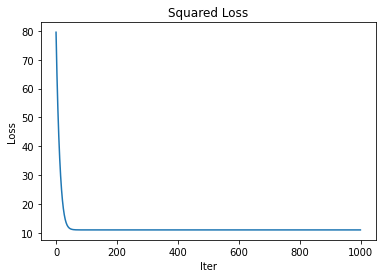

In [13]:
plt.plot(L)
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Squared Loss');

***Plot the predictions***

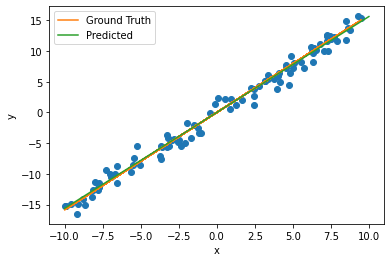

In [14]:
xlin = np.linspace(-10, 10, 100)
ypred = wpred*xlin

fig, ax = plt.subplots()
ax.plot(X_reg, y_reg, 'o')
ax.plot(X_reg, np.dot(X_reg, w), label='Ground Truth')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(xlin,ypred, label= 'Predicted')
plt.legend()
fig.show();

### Polynomial regression

Polynomial relationship between $x$ and $y$:

$$
y = w_0 + \sum_{j=1}^{\text{deg}-1} w_j x^j
$$

**Remark**: note that the regression function is linear in terms of the unknown variables $w$.

The squared loss is: 

$$
\mathcal{L}(w) = \frac{1}{n} \sum_{i=0}^n \big(y_i - \big(w_0 + \sum_{j=1}^{\text{deg}-1} w_j x_i^j\big)\big)^2 = \frac{1}{n} \sum_{i=0}^n \big(y_i - \hat{y}_i\big)^2
$$

In order to perform GD, we need the partial derivative of $\mathcal{L}$ w.r.t. each coefficient $w_j$:

$$
\frac{\partial\mathcal{L}}{\partial w_0} = - \frac{2}{n} \sum_{i=0}^n (y_i - \hat{y}_i)\ \text{with}\ j=0 \\
\frac{\partial\mathcal{L}}{\partial w_j} = - \frac{2}{n} \sum_{i=0}^n x_i^j \cdot (y_i - \hat{y}_i)\ \text{with}\ j\neq 0
$$

Then each coefficient is updated separately: 

$$
w_0^{(t+1)} = w_0^{(t)} - \gamma \frac{\partial\mathcal{L}}{\partial w_0}\ \text{with}\ j=0 \\
w_j^{(t+1)} = w_j^{(t)} - \gamma \frac{\partial\mathcal{L}}{\partial w_j}\ \text{with}\ j\neq0
$$

In [15]:
def evaluate_poly(X, w):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    w : array of float of dim deg
        Coefficients of the polynomial
    """
    # this is the actual degree - 1 because we have to consider the intercept
    deg = len(w)
    # column i is the i-th power of the datapoints
    X_pow = np.concatenate([np.power(X, i) for i in range(1, deg)], axis=1)
    return np.dot(X_pow, w[1:]) + w[0]

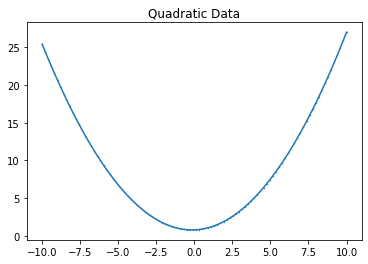

In [16]:
x_poly = np.linspace(-10, 10, 100).reshape(100, 1)
w = np.random.rand(3)
y_poly = evaluate_poly(x_poly, w)

fig, ax = plt.subplots()
ax.plot(x_poly, y_poly, '-o', markersize=.5)
plt.title('Quadratic Data')
fig.show();

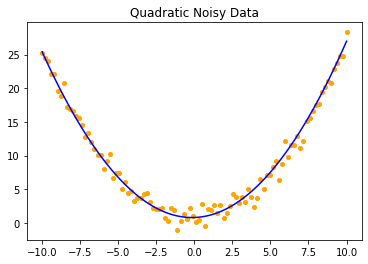

In [17]:
# add noise to the dataset 
eps = np.random.normal(0, 1, len(y_poly))
y_poly_noise = y_poly + eps

fig, ax = plt.subplots()
ax.plot(x_poly, y_poly_noise, 'o', markersize=4, c='orange')
ax.plot(x_poly, y_poly, '-', c='blue')
plt.title('Quadratic Noisy Data')
fig.show();

2. Implement GD for polynomial regression

  **Hint**: start with polynomials of degree $2$ then try to generalize to polynomials of arbitrary degree

In [18]:
def poly_squared_loss(x, y, w):
    """
    Parameters
    ----------
    X : array of float dim n x d
      Matrix containing the dataset
    y : array of float of dim n
      Vector containing the ground truth value of each data point
    w : array of float of dim deg
      Weights of the fitted polynomial
    """
    y_hat = evaluate_poly(x, w)
    return np.mean((y - y_hat)**2)
  


def poly_GD(X, y, iter, gamma, deg):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    deg : int
        Degree of the polynomial
    """
    points = X.shape[0]
    X_pow = np.concatenate([np.power(X, i) for i in range(deg+1)], axis=1)
    # initialization
    W = np.zeros((deg+1, iter)) # to store weights
    L = np.zeros(iter) # to store losses
    w = np.zeros(deg+1)
    # GD iterations
    for i in range(iter):
        W[:, i] = w
        y_hat = evaluate_poly(X, w)
        # derivative w.r.t. w_0
        w[0] = w[0] + (2*gamma/points)*np.sum(y - y_hat)
        # derivative w.r.t. w_j
        for d in range(1, len(w)):
          w[d] = w[d] + (2*gamma/points)*np.dot(X_pow[:, d].T, (y - y_hat))
        # loss evaluation
        L[i] = poly_squared_loss(X, y, w)
    return W, L

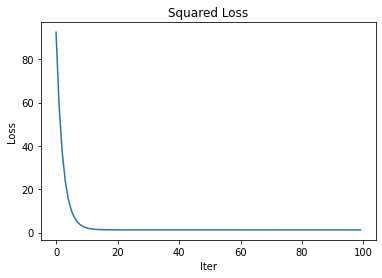

In [19]:
iter = 100
gamma = 0.00005
X_poly = x_poly.reshape(len(x_poly), 1)
w_poly_gd, l_poly = poly_GD(X_poly, y_poly_noise, iter, gamma, 2)

# plot loss
plt.plot(l_poly)
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Squared Loss');

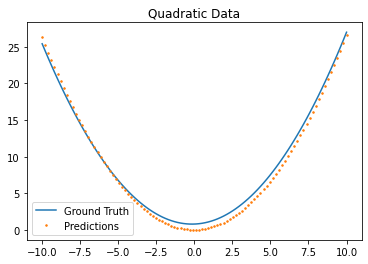

In [20]:
# plot predictions
w_poly = w_poly_gd[:, -1]
y_hat_poly = evaluate_poly(x_poly, w_poly)
fig, ax = plt.subplots()
ax.plot(x_poly, y_poly, '-', label='Ground Truth')
ax.plot(x_poly, y_hat_poly, 'o', label='Predictions', markersize=1.5)
plt.legend()
plt.title('Quadratic Data')
fig.show();

## Logistic Regression

### Generate the data and plot (noisy) data (cfr Lab 1)

In [21]:
def mixGauss(means, sigmas, n):
    """
    Parameters
    ----------
    means : matrix/list of float of dim n_classes x dim_data (d)
        Means of the Gaussian functions
    sigmas : array/list of float of dim n_classes
        Standard deviation of the Gaussian functions
    n : int
        Number of points for each class
    """
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = np.shape(means)[1] # the means matrix is of n_classes x dim_data
    num_classes = sigmas.size # the number of variances is the number of classes
    
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    # iterate over classes
    for idx, sigma in enumerate(sigmas):
        # generates n points around means[idx] with cov sigma[idx] 
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)   
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels == 0] = -1

    return data, labels

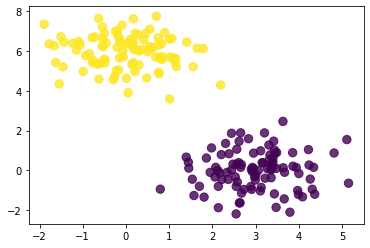

In [22]:
# usage example 
means = [[3,0],[0,6]]
sigmas = [0.9,0.9]
n = 100

X, labels = mixGauss(means, sigmas, n)

# plotting the generated dataset
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], s=70, c=labels, alpha=0.8)
fig.show()

In [23]:
def labelsnoise(perc, labels):
    """
    Parameters
    ----------
    perc : float 
        Percentage of labels to be flipped
    labels: array of int of dim n_classes
        Array containing labels idxs
    """
    points = np.shape(labels)[0]
    noisylabels = np.copy(np.squeeze(labels))
    n_flips = int(np.floor(points * perc / 100)) # floor: nearest integer by defect
    idx_to_flip = np.random.choice(points, size=n_flips, replace=False) # replace is false since the same index cannot be chosen twice
    noisylabels[idx_to_flip] = -noisylabels[idx_to_flip] # for binary this turns -1 into 1 and viceversa
    return noisylabels

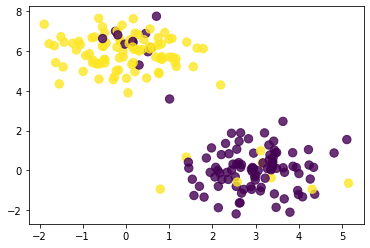

In [24]:
noisylabels = labelsnoise(10, labels)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], s=70, c=noisylabels, alpha=0.8)
fig.show()

***Sigmoidal function***

$$
\sigma(wx_i) = \frac{1}{1 + e^{-wx_i}}
$$

In [25]:
def sigmoid(x, w):
    """
    Parameters
    ----------
    x : array of dim n
        Array containing the datapoint
    w : float
        Number representing the 'temperature' of the sigmoid
    """
    y = 1/(1+np.exp(-np.dot(x,w)))
    return y

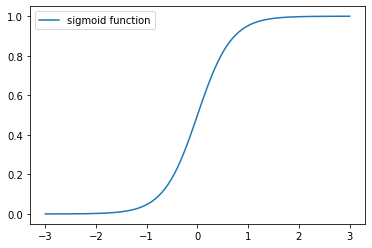

In [26]:
# usage example
x = np.linspace(-3,3,100)
w = 3
y = sigmoid(x, w)

fig, ax = plt.subplots()
ax.plot(x, y, label='sigmoid function')
plt.legend();
fig.show()

## Logistic Loss

* For regression the hypothesis was: $h(x)=w^Tx$
* For logistic regression is $h(x)=\sigma(wx)=\frac{1}{1+e^{-w^Tx}}$


$$
h(x) = 
\begin{cases}
  >0.5, & w^{T}x>0\\
  <0.5, & w^{T}x<0
\end{cases}
$$

The goal of the logistic regression algorithm is to learn $w$. 

Case specific (logarithmic) cost:


$$
cost = 
\begin{cases}
  -log(h(x)), & y=1\\
  -log(1-h(x)), & y=0
\end{cases}
$$

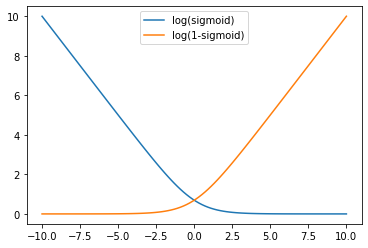

In [27]:
# plot case-specific cost
w = 1
x = np.linspace(-10,10,100)
plt.plot(x, -np.log(sigmoid(x,w)),label="log(sigmoid)")
plt.plot(x, -np.log(1-sigmoid(x,w)),label="log(1-sigmoid)")
plt.legend()
plt.show()

**Logistic loss**

Use to measure the goodness of fit of a logistic regression model.

$$
L=-y\cdot \log(h(x,w))-(1 - y)\cdot \log(1-h(x,w))
$$


**Minimization of the Logistic loss**

The gradient is given by:

$$
w_{j}\leftarrow w_{j}-\frac{\gamma}{n}\sum_{i=1}^{n}(y^{i}-h(x^{i}))x^{i}_{j}
$$
In compact form:

$$
w\leftarrow w -\frac{\gamma}{n}X^{T}(h(X)-y)
$$



In [28]:
def sigmoidM(X, w):
    """
    Parameters
    ----------
    X : array of dim n x d 
        Matrix containing the dataset
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    y = 1/(1+np.exp(-np.matmul(X,w)))
    return y


def LogisticLoss(X, labels, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    n = np.shape(X)[0]
    cost = -(1/n)*np.sum(labels*np.log(sigmoidM(X,w)) + (1-labels)*np.log(1-sigmoidM(X,w)))
    return cost

def GDLogistic(X, labels, iter, gamma):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    """
    d = np.shape(X)
    cost = np.zeros(iter)
    w = np.random.uniform(0, 0.01, d[1])
    W = np.zeros((2,iter))
    for i in range(iter):
        W[:,i] = w
        w = w-(2*gamma/d[0])*(np.transpose(X)@(sigmoidM(X,w)-labels))
        cost[i] = LogisticLoss(X,labels,w)
    return W,cost 

In [29]:
# usage example
iter = 500
gamma = 0.0001
W, cost = GDLogistic(X, noisylabels, iter, gamma)

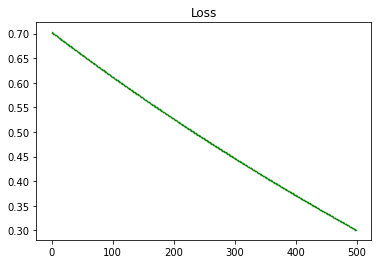

In [30]:
fig,ax =plt.subplots()
ax.plot(cost, 'go', markersize=0.5)
ax.set_title('Loss')
fig.show()

***Plotting the decision boundary***

The decision boundary is used to predict which class a new point might correspond to.

Its derivation is:

$$0=w^{T}x=x_{1}w_{1}+x_{2}w_{2}\rightarrow x_{2}=-\frac{x_{1}w_{1}}{w_{2}}$$

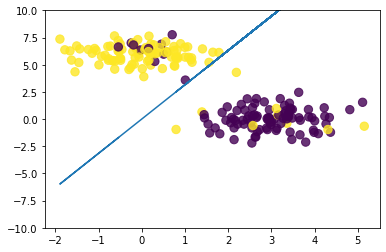

In [31]:
w = W[:,iter-1]
y = -(np.dot(X[:,0], w[0])/w[1])

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], s=70, c=noisylabels, alpha=0.8)
ax.plot(X[:,0], y)
plt.ylim([m, M])
fig.show()

## Accuracy

The accuracy is a metric used for classification problems defined as the number of correct predictions divided by the total number of predictions. 

In [32]:
def accuracy(X, w, labels):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    w : array of dim d
        Vector representing the coefficients of the logistic model
    labels : array of dim n
        Vector representing the ground truth label of each data point
    """
    a = labels - (2*np.round(sigmoidM(X,w))-1)
    acc = np.sum(a==0)/np.shape(X)[0]
    return acc

In [33]:
accuracy(X, w, noisylabels)

0.895

### Generate binary data with a separator

3. Repeat the experiment generating data with a linear separator (take the generating function from Lab 1).

In [34]:
def binary(a, b, points, m, M, d):
    """
    Parameters
    ----------
    a : float
        Angular coefficient of the separating line
    b : float
        Intercept of the separating line
    points : int
        Number of points to be generated
    m : float
        Lower bound for the domain of the data points
    M : float
        Upper bound for the domain of the data points
    d : int
        Dimension of each data sample
    """
    X = np.zeros((points,d))
    labels = np.zeros(points)
    
    for i in range(points):
        X[i,:] = np.random.uniform(m, M, d)
    
    labels[X[:,1]-a*X[:,0]-b>=0] = 1
    labels[X[:,1]-a*X[:,0]-b<0] = -1
    return X, labels  

In [35]:
def flipLabels(perc, Y):
    """
    Parameters
    ----------
    perc : float 
        Percentage of labels to be flipped
    Y: array of int of dim n_points
        Array containing the class idx of each data point
    """
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

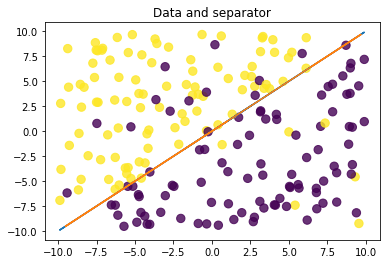

In [36]:
X, labels = binary(1, 0, 200, -10, 10, 2)
labels = flipLabels(10, labels)

# plotting the generated dataset
fig,ax=plt.subplots()
ax.scatter(X[:,0], X[:,1], s=70, c=labels, alpha=0.8)
ax.plot(X, 1*X+0)
ax.set_title('Data and separator')
plt.show()

Accuracy:  0.895


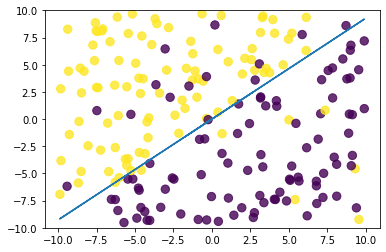

In [37]:
iter = 700
gamma = 0.0005
W, cost = GDLogistic(X, labels, iter, gamma)
w = W[:,iter-1]
boundary = -(np.dot(X[:,0], w[0])/w[1])

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], s=70, c=labels, alpha=0.8)
ax.plot(X[:,0], boundary)
plt.ylim([m, M])
fig.show()

print('Accuracy: ', accuracy(X, w, labels))

4. Explore the `scikit-learn` functions for linear and logistic regression.

* Linear Regression: [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

MSE:  0.008663623444291084


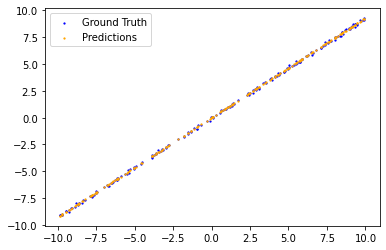

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = datagen(1, 1000, -10, 10, np.random.normal(0, 1, d), 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

plt.scatter(X_test, y_test, color='blue', label='Ground Truth', s=1.5)
plt.scatter(X_test, y_pred, color='orange', label='Predictions', s=1.5)
plt.legend()
plt.show()

* Logistic Regression: [LogisticRregression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X, labels = mixGauss([[0, 3], [0, 6]], [0.9, 0.9], 1000)
labels = labelsnoise(10, labels)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=26, shuffle=True)

log_reg = LogisticRegression(penalty='none').fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', acc)

Accuracy:  0.825
